In [449]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import initializers

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV



#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [450]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [451]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [452]:
def join_data(observed, estimated, labels):
    #Remove hour and minute values
    observed = observed.assign(date_forecast=observed.date_forecast.dt.round('H'))
    estimated = estimated.assign(date_forecast=estimated.date_forecast.dt.round('H'))
    
    #rename columns names to match
    observed = observed.rename(columns={'date_forecast': 'date'})
    estimated = estimated.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    data = pd.concat([observed, estimated])
    joined_data = pd.merge(data, labels, how="inner", on="date")
    
    return joined_data
    

In [453]:
def remove_unused_columns(df):
    df = df.drop(['wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                 'wind_speed_w_1000hPa:ms'], axis=1)
    return df


In [454]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in test.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    train.drop(constanst_columns, axis=1,inplace=True)
    val.drop(constanst_columns, axis=1,inplace=True)
    test.drop(constanst_columns, axis=1,inplace=True)

In [455]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
   

In [456]:
def feature_date(df):
    df["month"] = [df["date"][i].month for i in range(len(df))]
    df["hour"] = [df["date"][i].hour for i in range(len(df))]
    df.pop('date')


In [457]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [458]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", 'is_in_shadow:idx', 'Hour sin', 'Hour cos',"Year sin", "Year cos", "month", "Hour", "pv_measurement"]
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [459]:
def combine_features(df, features, new_name):
    
    totals = []
    
    for i in range(len(df)):
        total = 0
        for feature in features:
            total += df[feature][i]
        
        totals.append(total)
            
   
    #df.drop(features, axis=1, inplace=True)
    df[new_name] = totals
    df[new_name] = df[new_name] #/ df[new_name].max()

In [460]:
def split_data(df):
    val_split = 0.15
    val_months = [5, 6, 7]

    len_df = len(df)
    val_length = int(len_df * val_split)

    current_val_indices = []

    for i in range(0, len(df)):
        if int(df["date"][i].month) in val_months:
            current_val_indices.append(i)

        if len(current_val_indices) >= val_length:
            break


    validation_rows = df.iloc[current_val_indices]
    training_rows = df.drop(current_val_indices, axis=0)
    
    
    training_rows = training_rows.reset_index()
    training_rows = training_rows.drop(['index'], axis=1)
    
    validation_rows = validation_rows.reset_index()
    validation_rows = validation_rows.drop(['index'], axis=1)
    
    return training_rows, validation_rows

In [461]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [462]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [463]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [464]:
data_a = join_data(X_train_observed_a, X_train_estimated_a, train_a)
data_b = join_data(X_train_observed_b, X_train_estimated_b, train_b)
data_c = join_data(X_train_observed_c, X_train_estimated_c, train_c)

In [465]:
#plt.plot(data_b['pv_measurement'])

#plt.axvline(x=10800, color="red")
#plt.axvline(x=11500, color="blue")

#plt.axvline(x=13250, color="red")
#plt.axvline(x=14700, color="blue")

#plt.axvline(x=18000, color="red")
#plt.axvline(x=20000, color="blue")

data_b = data_b.drop(data_b.index[10800:11500])
data_b = data_b.drop(data_b.index[13250:14700])
data_b = data_b.drop(data_b.index[18000:20000])

data_b = data_b.reset_index()
data_b = data_b.drop(['index'], axis=1)

In [466]:
train_data_a, val_data_a = split_data(data_a)
train_data_b, val_data_b = split_data(data_b)
train_data_c, val_data_c = split_data(data_c)

In [467]:
# Remove columns which are not needed
#train_data_a = remove_unused_columns(train_data_a)
#val_data_a = remove_unused_columns(val_data_a)
#test_a = remove_unused_columns(test_a)

#train_data_b = remove_unused_columns(train_data_b)
#val_data_b = remove_unused_columns(val_data_b)
#test_b = remove_unused_columns(test_b)

#train_data_c = remove_unused_columns(train_data_c)
#val_data_c = remove_unused_columns(val_data_c)
#test_c = remove_unused_columns(test_c) 

In [468]:
#Convert date into sin and cos components
convert_date_to_sin_and_cos(train_data_a)
convert_date_to_sin_and_cos(val_data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(train_data_b)
convert_date_to_sin_and_cos(val_data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(train_data_c)
convert_date_to_sin_and_cos(val_data_c)
convert_date_to_sin_and_cos(test_c)


#Extract date components
#feature_date(train_data_a)
#feature_date(val_data_a)
#feature_date(test_a)

#feature_date(train_data_b)
#feature_date(val_data_b)
#feature_date(test_b)

#feature_date(train_data_c)
#feature_date(val_data_c)
#feature_date(test_c)

In [469]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [470]:
#normalize_except_columns(train_data_a)
#normalize_except_columns(val_data_a)
#normalize_except_columns(test_a)

#normalize_except_columns(train_data_b)
#normalize_except_columns(val_data_b)
#normalize_except_columns(test_b)

#normalize_except_columns(train_data_c)
#normalize_except_columns(val_data_c)
#normalize_except_columns(test_c)

In [471]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [472]:
combine_features(train_data_a, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(val_data_a, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_a, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(train_data_a, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(val_data_a, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_a, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')


combine_features(train_data_b, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(val_data_b, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_b, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(train_data_b, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(val_data_b, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_b, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')


combine_features(train_data_c, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(val_data_c, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_c, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(train_data_c, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(val_data_c, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_c, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')

In [473]:
train_data_c = train_data_c[5800:]
train_data_b = train_data_b.drop(train_data_b.index[13410:14460])
train_data_b = train_data_b.drop(train_data_b.index[18000:20000])
train_data_b = train_data_b.reset_index()
train_data_c = train_data_c.reset_index()
train_data_b = train_data_b.drop(['index'], axis=1)
train_data_c = train_data_c.drop(['index'], axis=1)

In [474]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [475]:
def modelfit(alg, xs, ys, val_xs, val_ys, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xs, label=ys)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xs, ys, eval_set=[(xs, ys),(val_xs, val_ys)], verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xs)
    dval_predictions = alg.predict(val_xs)
    
    mae = mean_absolute_error(dtrain_predictions, ys)
    mae_val = mean_absolute_error(dval_predictions, val_ys)
    print(mae, mae_val)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [476]:
import gc
gc.collect()

8485

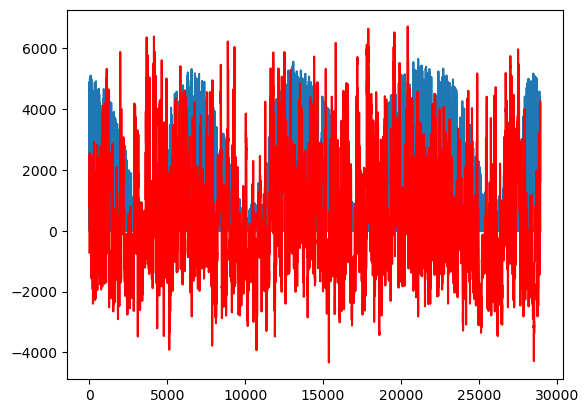

In [499]:
plt.plot(train_a_y)
plt.plot(train_data_a['wind_speed_u_10m:ms']*600, color="red")
#plt.plot(train_data_a['global_rad_1h:J'] / 1000, color="green")
#plt.plot(train_data_a['direct_rad_1h:J'] / 1000, color="blue")
#plt.plot(train_data_a['diffuse_rad_1h:J'] / 1000, color="pink")





#train_data_a.describe().transpose()

[13:24:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:24:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:24:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:24:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:24:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	train-mae:496.37188+2.07992	test-mae:496.37977+8.55698
[1]	train-mae:474.43906+1.85914	test-mae:474.49962+8.58754
[2]	train-mae:453.47882+1.81592	test-mae:453.55414+8.38209
[3]	train-mae:433.86644+1.78237	test-mae:433.96677+8.19090
[4]	train-mae:415.37186+1.64631	test-mae:415.54912+8.11008
[5]	t

[125]	train-mae:122.61119+1.07871	test-mae:155.50413+3.41158
[126]	train-mae:122.35962+1.12273	test-mae:155.42788+3.42118
[127]	train-mae:122.12208+1.08996	test-mae:155.34543+3.43211
[128]	train-mae:121.84003+1.06375	test-mae:155.26691+3.45587
[129]	train-mae:121.58663+1.05262	test-mae:155.18138+3.47219
[130]	train-mae:121.32779+1.04796	test-mae:155.11181+3.51306
[131]	train-mae:121.07424+1.03917	test-mae:155.04308+3.55530
[132]	train-mae:120.81774+1.00763	test-mae:154.97096+3.56870
[133]	train-mae:120.58474+1.03249	test-mae:154.89665+3.55404
[134]	train-mae:120.38347+1.05176	test-mae:154.85026+3.57467
[135]	train-mae:120.11748+1.03155	test-mae:154.77376+3.55747
[136]	train-mae:119.88132+1.03192	test-mae:154.71812+3.56706
[137]	train-mae:119.68391+1.03284	test-mae:154.70487+3.53638
[138]	train-mae:119.49593+0.95949	test-mae:154.67702+3.52755
[139]	train-mae:119.23702+1.00050	test-mae:154.57102+3.53824
[140]	train-mae:119.00372+1.02116	test-mae:154.50484+3.52893
[141]	train-mae:118.7824

[260]	train-mae:97.24020+0.55289	test-mae:150.05454+3.34956
[261]	train-mae:97.13674+0.52363	test-mae:150.04862+3.34971
[262]	train-mae:97.01289+0.49633	test-mae:150.03713+3.36461
[263]	train-mae:96.84607+0.50816	test-mae:149.99730+3.35674
[264]	train-mae:96.70726+0.49504	test-mae:149.97306+3.35416
[265]	train-mae:96.51185+0.53304	test-mae:149.93489+3.32699
[266]	train-mae:96.37338+0.54831	test-mae:149.90248+3.31329
[267]	train-mae:96.18111+0.54725	test-mae:149.86737+3.29090
[268]	train-mae:96.01104+0.50563	test-mae:149.83580+3.29558
[269]	train-mae:95.83882+0.47842	test-mae:149.82808+3.30471
[270]	train-mae:95.70183+0.52453	test-mae:149.81403+3.30941
[271]	train-mae:95.55602+0.50892	test-mae:149.79282+3.32556
[272]	train-mae:95.42756+0.51265	test-mae:149.78429+3.31953
[273]	train-mae:95.29185+0.51260	test-mae:149.75955+3.32933
[274]	train-mae:95.12546+0.53865	test-mae:149.73414+3.30742
[275]	train-mae:94.99464+0.53619	test-mae:149.71218+3.31161
[276]	train-mae:94.85887+0.57483	test-ma

[397]	train-mae:79.18741+0.45262	test-mae:147.27876+3.11231
[398]	train-mae:79.08052+0.46724	test-mae:147.26637+3.11331
[399]	train-mae:78.95362+0.49328	test-mae:147.25189+3.12001
[400]	train-mae:78.84633+0.47409	test-mae:147.23144+3.12618
[401]	train-mae:78.75424+0.48431	test-mae:147.22430+3.13143
[402]	train-mae:78.63674+0.50248	test-mae:147.21180+3.14004
[403]	train-mae:78.53252+0.48647	test-mae:147.19752+3.14082
[404]	train-mae:78.42407+0.49948	test-mae:147.17446+3.14158
[405]	train-mae:78.33673+0.50091	test-mae:147.17382+3.14373
[406]	train-mae:78.22788+0.51654	test-mae:147.16348+3.14051
[407]	train-mae:78.13711+0.50870	test-mae:147.15850+3.13917
[408]	train-mae:78.04317+0.49829	test-mae:147.16404+3.14397
[409]	train-mae:77.95547+0.47604	test-mae:147.15761+3.13631
[410]	train-mae:77.83981+0.49576	test-mae:147.13713+3.14330
[411]	train-mae:77.75152+0.48067	test-mae:147.13128+3.14685
[412]	train-mae:77.65030+0.45802	test-mae:147.12717+3.13439
[413]	train-mae:77.56144+0.48728	test-ma

[534]	train-mae:66.21059+0.62996	test-mae:145.63393+2.98980
[535]	train-mae:66.10840+0.63067	test-mae:145.60307+3.00558
[536]	train-mae:66.01834+0.63103	test-mae:145.59461+3.00850
[537]	train-mae:65.95814+0.63031	test-mae:145.58981+3.00577
[538]	train-mae:65.87126+0.64927	test-mae:145.57563+3.00318
[539]	train-mae:65.79116+0.60682	test-mae:145.55910+3.00709
[540]	train-mae:65.69198+0.60094	test-mae:145.54952+3.00596
[541]	train-mae:65.61282+0.60407	test-mae:145.55116+3.00402
[542]	train-mae:65.55968+0.61612	test-mae:145.54540+3.00867
[543]	train-mae:65.47362+0.63388	test-mae:145.54692+3.00955
[544]	train-mae:65.39473+0.65254	test-mae:145.52956+3.00459
[545]	train-mae:65.29615+0.63597	test-mae:145.50367+3.00293
[546]	train-mae:65.20732+0.62742	test-mae:145.48657+2.99615
[547]	train-mae:65.13091+0.60737	test-mae:145.47919+2.99290
[548]	train-mae:65.01348+0.61216	test-mae:145.44907+2.97640
[549]	train-mae:64.95221+0.62682	test-mae:145.44262+2.98477
[550]	train-mae:64.87619+0.63777	test-ma

[671]	train-mae:55.84153+0.38022	test-mae:144.24884+2.77587
[672]	train-mae:55.76913+0.39356	test-mae:144.24483+2.78183
[673]	train-mae:55.67774+0.39291	test-mae:144.23387+2.78999
[674]	train-mae:55.61430+0.39746	test-mae:144.22633+2.77843
[675]	train-mae:55.54272+0.38813	test-mae:144.21863+2.78333
[676]	train-mae:55.49289+0.39642	test-mae:144.21105+2.79241
[677]	train-mae:55.43396+0.40431	test-mae:144.20417+2.79700
[678]	train-mae:55.39119+0.39966	test-mae:144.20331+2.79634
[679]	train-mae:55.32539+0.38891	test-mae:144.19708+2.79818
[680]	train-mae:55.26370+0.38772	test-mae:144.19142+2.79229
[681]	train-mae:55.20119+0.38419	test-mae:144.17898+2.78351
[682]	train-mae:55.12798+0.39532	test-mae:144.16334+2.78692
[683]	train-mae:55.04250+0.39426	test-mae:144.15433+2.78553
[684]	train-mae:54.96845+0.39291	test-mae:144.14263+2.78429
[685]	train-mae:54.89801+0.40121	test-mae:144.13020+2.78980
[686]	train-mae:54.82492+0.40763	test-mae:144.11633+2.80023
[687]	train-mae:54.76594+0.42397	test-ma

[808]	train-mae:47.45008+0.63602	test-mae:143.15856+2.65477
[809]	train-mae:47.37604+0.62827	test-mae:143.14874+2.64834
[810]	train-mae:47.32981+0.62786	test-mae:143.14825+2.64710
[811]	train-mae:47.28750+0.63598	test-mae:143.14089+2.64605
[812]	train-mae:47.22136+0.62777	test-mae:143.11883+2.65244
[813]	train-mae:47.15938+0.63843	test-mae:143.11619+2.65337
[814]	train-mae:47.10972+0.65085	test-mae:143.11016+2.65131
[815]	train-mae:47.04240+0.65594	test-mae:143.09999+2.65100
[816]	train-mae:46.99994+0.65461	test-mae:143.10155+2.65319
[817]	train-mae:46.94241+0.66689	test-mae:143.09881+2.65519
[818]	train-mae:46.88020+0.66092	test-mae:143.09030+2.65645
[819]	train-mae:46.82373+0.65981	test-mae:143.08333+2.64941
[820]	train-mae:46.78493+0.67359	test-mae:143.08155+2.64220
[821]	train-mae:46.73126+0.66812	test-mae:143.07436+2.64758
[822]	train-mae:46.67034+0.65763	test-mae:143.06291+2.64009
[823]	train-mae:46.60596+0.65462	test-mae:143.05825+2.63500
[824]	train-mae:46.55469+0.63712	test-ma

[945]	train-mae:40.45955+0.57801	test-mae:142.31964+2.49458
[946]	train-mae:40.40771+0.58111	test-mae:142.31877+2.49594
[947]	train-mae:40.35304+0.58953	test-mae:142.31521+2.50545
[948]	train-mae:40.30942+0.58409	test-mae:142.30632+2.50391
[949]	train-mae:40.25594+0.57162	test-mae:142.29303+2.49609
[950]	train-mae:40.22245+0.55868	test-mae:142.29574+2.49227
[951]	train-mae:40.18192+0.54175	test-mae:142.29095+2.48980
[952]	train-mae:40.14431+0.53143	test-mae:142.28847+2.48696
[953]	train-mae:40.09938+0.52042	test-mae:142.29121+2.48848
[954]	train-mae:40.06327+0.51990	test-mae:142.28633+2.49443
[955]	train-mae:40.02600+0.52483	test-mae:142.28417+2.49310
[956]	train-mae:39.97425+0.51562	test-mae:142.27688+2.49371
[957]	train-mae:39.93351+0.50878	test-mae:142.27077+2.48727
[958]	train-mae:39.89363+0.49170	test-mae:142.27005+2.48690
[959]	train-mae:39.83724+0.48580	test-mae:142.25814+2.47794
[960]	train-mae:39.78955+0.47702	test-mae:142.24942+2.46946
[961]	train-mae:39.74361+0.45974	test-ma

[1081]	train-mae:34.59809+0.42526	test-mae:141.62663+2.41361
[1082]	train-mae:34.56460+0.42677	test-mae:141.62121+2.41587
[1083]	train-mae:34.53214+0.43723	test-mae:141.61601+2.41806
[1084]	train-mae:34.49802+0.43981	test-mae:141.61195+2.41962
[1085]	train-mae:34.46054+0.42517	test-mae:141.61200+2.41772
[1086]	train-mae:34.42736+0.42066	test-mae:141.61100+2.41359
[1087]	train-mae:34.38628+0.42723	test-mae:141.60579+2.40984
[1088]	train-mae:34.34986+0.42449	test-mae:141.60376+2.41042
[1089]	train-mae:34.31264+0.41719	test-mae:141.59990+2.40952
[1090]	train-mae:34.27333+0.43025	test-mae:141.59537+2.40642
[1091]	train-mae:34.22658+0.43160	test-mae:141.59313+2.40131
[1092]	train-mae:34.18902+0.42617	test-mae:141.58934+2.40427
[1093]	train-mae:34.14964+0.42726	test-mae:141.58336+2.40657
[1094]	train-mae:34.12323+0.42295	test-mae:141.58261+2.40526
[1095]	train-mae:34.08208+0.41853	test-mae:141.58378+2.40368
[1096]	train-mae:34.05066+0.41715	test-mae:141.58365+2.40627
[1097]	train-mae:34.0135

[1216]	train-mae:29.80530+0.49074	test-mae:141.15335+2.37956
[1217]	train-mae:29.77154+0.49463	test-mae:141.15283+2.38174
[1218]	train-mae:29.73333+0.49317	test-mae:141.15337+2.38182
[1219]	train-mae:29.69224+0.49400	test-mae:141.14354+2.38116
[1220]	train-mae:29.65776+0.49273	test-mae:141.14320+2.37830
[1221]	train-mae:29.62018+0.49142	test-mae:141.13892+2.37879
[1222]	train-mae:29.57436+0.49310	test-mae:141.12906+2.37774
[1223]	train-mae:29.53711+0.48503	test-mae:141.12338+2.37414
[1224]	train-mae:29.50452+0.47802	test-mae:141.12442+2.37053
[1225]	train-mae:29.48094+0.48466	test-mae:141.12310+2.36928
[1226]	train-mae:29.44995+0.48139	test-mae:141.11735+2.36738
[1227]	train-mae:29.42303+0.47679	test-mae:141.11290+2.36702
[1228]	train-mae:29.40138+0.47379	test-mae:141.11232+2.36846
[1229]	train-mae:29.37576+0.46910	test-mae:141.11158+2.36964
[1230]	train-mae:29.34604+0.47569	test-mae:141.11048+2.36990
[1231]	train-mae:29.31032+0.47150	test-mae:141.10706+2.36453
[1232]	train-mae:29.2811

[1351]	train-mae:25.90496+0.37924	test-mae:140.82817+2.31457
[1352]	train-mae:25.87852+0.38089	test-mae:140.82471+2.31572
[1353]	train-mae:25.84730+0.38139	test-mae:140.82012+2.31535
[1354]	train-mae:25.81650+0.38219	test-mae:140.81494+2.31591
[1355]	train-mae:25.78632+0.37992	test-mae:140.81491+2.32009
[1356]	train-mae:25.75937+0.37521	test-mae:140.81094+2.32168
[1357]	train-mae:25.72207+0.37509	test-mae:140.80356+2.32307
[1358]	train-mae:25.68738+0.37539	test-mae:140.80281+2.32052
[1359]	train-mae:25.66212+0.36905	test-mae:140.79716+2.31799
[1360]	train-mae:25.63371+0.36388	test-mae:140.79824+2.31494
[1361]	train-mae:25.60490+0.36410	test-mae:140.79454+2.31380
[1362]	train-mae:25.58018+0.36841	test-mae:140.79057+2.30943
[1363]	train-mae:25.55311+0.36624	test-mae:140.78680+2.31113
[1364]	train-mae:25.52670+0.36926	test-mae:140.78122+2.31608
[1365]	train-mae:25.50479+0.37359	test-mae:140.78021+2.31493
[1366]	train-mae:25.47435+0.36947	test-mae:140.77466+2.30811
[1367]	train-mae:25.4422

[1486]	train-mae:22.46699+0.34941	test-mae:140.49280+2.28443
[1487]	train-mae:22.44449+0.34758	test-mae:140.49268+2.28343
[1488]	train-mae:22.41828+0.35115	test-mae:140.49106+2.28285
[1489]	train-mae:22.39442+0.34328	test-mae:140.48611+2.28035
[1490]	train-mae:22.36962+0.34681	test-mae:140.48351+2.27946
[1491]	train-mae:22.34786+0.33871	test-mae:140.48313+2.27722
[1492]	train-mae:22.32498+0.34189	test-mae:140.47961+2.27508
[1493]	train-mae:22.30711+0.34869	test-mae:140.47750+2.27767
[1494]	train-mae:22.27754+0.34382	test-mae:140.47358+2.27832
[1495]	train-mae:22.25591+0.34120	test-mae:140.47081+2.27694
[1496]	train-mae:22.23390+0.34468	test-mae:140.46932+2.27706
[1497]	train-mae:22.20936+0.33953	test-mae:140.46577+2.28246
[1498]	train-mae:22.18737+0.33621	test-mae:140.46379+2.28261
[1499]	train-mae:22.16219+0.33559	test-mae:140.46164+2.27949
[1500]	train-mae:22.13708+0.33335	test-mae:140.45906+2.27940
[1501]	train-mae:22.11977+0.33554	test-mae:140.45794+2.28178
[1502]	train-mae:22.0967

[1621]	train-mae:19.56746+0.31904	test-mae:140.23616+2.26877
[1622]	train-mae:19.54596+0.31922	test-mae:140.23321+2.26834
[1623]	train-mae:19.52465+0.32050	test-mae:140.23205+2.26685
[1624]	train-mae:19.50469+0.31875	test-mae:140.22950+2.26770
[1625]	train-mae:19.48644+0.32530	test-mae:140.22849+2.26879
[1626]	train-mae:19.46760+0.31622	test-mae:140.22609+2.26775
[1627]	train-mae:19.44689+0.31704	test-mae:140.22657+2.26655
[1628]	train-mae:19.43116+0.31704	test-mae:140.22451+2.26482
[1629]	train-mae:19.41297+0.31623	test-mae:140.22364+2.26333
[1630]	train-mae:19.39283+0.32324	test-mae:140.22248+2.26530
[1631]	train-mae:19.37412+0.32395	test-mae:140.22089+2.26638
[1632]	train-mae:19.35647+0.32115	test-mae:140.21843+2.26666
[1633]	train-mae:19.33591+0.32083	test-mae:140.21953+2.26306
[1634]	train-mae:19.31387+0.32290	test-mae:140.21607+2.26330
[1635]	train-mae:19.29169+0.32341	test-mae:140.21328+2.25728
[1636]	train-mae:19.27147+0.32603	test-mae:140.21096+2.25615
[1637]	train-mae:19.2514

[1756]	train-mae:17.05161+0.33277	test-mae:139.99988+2.26730
[1757]	train-mae:17.03426+0.33183	test-mae:140.00174+2.26767
[1758]	train-mae:17.01867+0.32678	test-mae:139.99933+2.26715
[1759]	train-mae:17.00423+0.32335	test-mae:139.99794+2.26643
[1760]	train-mae:16.98898+0.32808	test-mae:139.99704+2.26435
[1761]	train-mae:16.96629+0.32721	test-mae:139.99608+2.26700
[1762]	train-mae:16.94786+0.32062	test-mae:139.99512+2.26781
[1763]	train-mae:16.93759+0.31450	test-mae:139.99648+2.26698
[1764]	train-mae:16.91773+0.31346	test-mae:139.99593+2.26631
[1765]	train-mae:16.89889+0.31149	test-mae:139.99327+2.26812
[1766]	train-mae:16.88572+0.31023	test-mae:139.99078+2.26751
[1767]	train-mae:16.87163+0.30604	test-mae:139.99071+2.26729
[1768]	train-mae:16.85218+0.30643	test-mae:139.99047+2.26706
[1769]	train-mae:16.83514+0.30715	test-mae:139.98965+2.26981
[1770]	train-mae:16.81794+0.30767	test-mae:139.98648+2.27060
[1771]	train-mae:16.79820+0.30567	test-mae:139.98621+2.27124
[1772]	train-mae:16.7783

[1891]	train-mae:14.96900+0.25991	test-mae:139.85365+2.26681
[1892]	train-mae:14.95018+0.25892	test-mae:139.85113+2.26705
[1893]	train-mae:14.93340+0.26064	test-mae:139.85024+2.26786
[1894]	train-mae:14.92004+0.25930	test-mae:139.85018+2.26734
[1895]	train-mae:14.90360+0.25601	test-mae:139.85038+2.26658
[1896]	train-mae:14.89079+0.25766	test-mae:139.84911+2.26748
[1897]	train-mae:14.87806+0.25583	test-mae:139.84499+2.26874
[1898]	train-mae:14.86217+0.25590	test-mae:139.84432+2.27028
[1899]	train-mae:14.84435+0.25499	test-mae:139.84146+2.27157
[1900]	train-mae:14.82995+0.25817	test-mae:139.84261+2.26877
[1901]	train-mae:14.81223+0.25513	test-mae:139.84107+2.26911
[1902]	train-mae:14.80015+0.25485	test-mae:139.84001+2.26891
[1903]	train-mae:14.78718+0.25329	test-mae:139.84067+2.26718
[1904]	train-mae:14.77253+0.25181	test-mae:139.83890+2.26613
[1905]	train-mae:14.75744+0.25400	test-mae:139.83730+2.26552
[1906]	train-mae:14.74289+0.25581	test-mae:139.83591+2.26340
[1907]	train-mae:14.7326

[2026]	train-mae:13.15965+0.19084	test-mae:139.71190+2.27070
[2027]	train-mae:13.14751+0.19054	test-mae:139.71179+2.27026
[2028]	train-mae:13.13313+0.18892	test-mae:139.70942+2.27239
[2029]	train-mae:13.11882+0.18706	test-mae:139.70871+2.27167
[2030]	train-mae:13.10897+0.18770	test-mae:139.70755+2.27084
[2031]	train-mae:13.09840+0.18766	test-mae:139.70725+2.26986
[2032]	train-mae:13.08469+0.18875	test-mae:139.70758+2.26921
[2033]	train-mae:13.07369+0.18530	test-mae:139.70679+2.26947
[2034]	train-mae:13.06075+0.18696	test-mae:139.70511+2.26925
[2035]	train-mae:13.04682+0.18694	test-mae:139.70381+2.26822
[2036]	train-mae:13.03534+0.18601	test-mae:139.70257+2.26753
[2037]	train-mae:13.01774+0.18259	test-mae:139.70194+2.26700
[2038]	train-mae:13.00793+0.18227	test-mae:139.70248+2.26712
[2039]	train-mae:12.99177+0.18312	test-mae:139.70116+2.26723
[2040]	train-mae:12.97885+0.18061	test-mae:139.69906+2.26658
[2041]	train-mae:12.96490+0.18183	test-mae:139.69903+2.26606
[2042]	train-mae:12.9514

[86]	validation_0-mae:136.44899	validation_1-mae:358.89313
[87]	validation_0-mae:136.01217	validation_1-mae:358.80752
[88]	validation_0-mae:135.45255	validation_1-mae:358.88402
[89]	validation_0-mae:135.04511	validation_1-mae:358.51002
[90]	validation_0-mae:134.57606	validation_1-mae:358.25332
[91]	validation_0-mae:134.13266	validation_1-mae:358.08767
[92]	validation_0-mae:133.58774	validation_1-mae:358.08870
[93]	validation_0-mae:133.10616	validation_1-mae:357.93676
[94]	validation_0-mae:132.62841	validation_1-mae:357.88960
[95]	validation_0-mae:132.08894	validation_1-mae:357.70197
[96]	validation_0-mae:131.50417	validation_1-mae:357.82497
[97]	validation_0-mae:131.16835	validation_1-mae:357.65928
[98]	validation_0-mae:130.70790	validation_1-mae:357.58791
[99]	validation_0-mae:130.18287	validation_1-mae:357.44863
[100]	validation_0-mae:129.83291	validation_1-mae:357.23845
[101]	validation_0-mae:129.38176	validation_1-mae:357.29507
[102]	validation_0-mae:128.90531	validation_1-mae:357.

[223]	validation_0-mae:103.67662	validation_1-mae:359.21925
[224]	validation_0-mae:103.55591	validation_1-mae:359.28143
[225]	validation_0-mae:103.46336	validation_1-mae:359.35614
[226]	validation_0-mae:103.35740	validation_1-mae:359.39272
[227]	validation_0-mae:103.10654	validation_1-mae:359.36727
[228]	validation_0-mae:102.93770	validation_1-mae:359.35166
[229]	validation_0-mae:102.78588	validation_1-mae:359.33009
[230]	validation_0-mae:102.58701	validation_1-mae:359.33017
[231]	validation_0-mae:102.36708	validation_1-mae:359.41664
[232]	validation_0-mae:102.11914	validation_1-mae:359.32844
[233]	validation_0-mae:101.89535	validation_1-mae:359.45344
[234]	validation_0-mae:101.77253	validation_1-mae:359.47989
[235]	validation_0-mae:101.64064	validation_1-mae:359.47125
[236]	validation_0-mae:101.46361	validation_1-mae:359.51307
[237]	validation_0-mae:101.29233	validation_1-mae:359.58562
[238]	validation_0-mae:101.17544	validation_1-mae:359.62908
[239]	validation_0-mae:101.08585	validat

[362]	validation_0-mae:84.44650	validation_1-mae:362.78758
[363]	validation_0-mae:84.31649	validation_1-mae:362.76615
[364]	validation_0-mae:84.23636	validation_1-mae:362.78698
[365]	validation_0-mae:84.14213	validation_1-mae:362.77911
[366]	validation_0-mae:83.97847	validation_1-mae:362.85150
[367]	validation_0-mae:83.92656	validation_1-mae:362.85654
[368]	validation_0-mae:83.83938	validation_1-mae:362.86662
[369]	validation_0-mae:83.68610	validation_1-mae:362.90194
[370]	validation_0-mae:83.53530	validation_1-mae:362.95411
[371]	validation_0-mae:83.37762	validation_1-mae:362.96110
[372]	validation_0-mae:83.21215	validation_1-mae:363.01727
[373]	validation_0-mae:83.00833	validation_1-mae:363.11826
[374]	validation_0-mae:82.89181	validation_1-mae:363.17674
[375]	validation_0-mae:82.74210	validation_1-mae:363.20793
[376]	validation_0-mae:82.69061	validation_1-mae:363.23672
[377]	validation_0-mae:82.52680	validation_1-mae:363.24014
[378]	validation_0-mae:82.48045	validation_1-mae:363.255

[501]	validation_0-mae:71.11076	validation_1-mae:366.10225
[502]	validation_0-mae:71.05275	validation_1-mae:366.11318
[503]	validation_0-mae:70.96115	validation_1-mae:366.11838
[504]	validation_0-mae:70.85155	validation_1-mae:366.11266
[505]	validation_0-mae:70.75311	validation_1-mae:366.08913
[506]	validation_0-mae:70.67416	validation_1-mae:366.12776
[507]	validation_0-mae:70.59272	validation_1-mae:366.21274
[508]	validation_0-mae:70.52928	validation_1-mae:366.24035
[509]	validation_0-mae:70.44402	validation_1-mae:366.26957
[510]	validation_0-mae:70.34352	validation_1-mae:366.28478
[511]	validation_0-mae:70.20685	validation_1-mae:366.28650
[512]	validation_0-mae:70.11589	validation_1-mae:366.30734
[513]	validation_0-mae:70.05158	validation_1-mae:366.32418
[514]	validation_0-mae:69.92318	validation_1-mae:366.30607
[515]	validation_0-mae:69.83131	validation_1-mae:366.32433
[516]	validation_0-mae:69.75029	validation_1-mae:366.30663
[517]	validation_0-mae:69.72061	validation_1-mae:366.308

[640]	validation_0-mae:59.39705	validation_1-mae:367.71070
[641]	validation_0-mae:59.35573	validation_1-mae:367.69175
[642]	validation_0-mae:59.33151	validation_1-mae:367.69199
[643]	validation_0-mae:59.25953	validation_1-mae:367.69432
[644]	validation_0-mae:59.24329	validation_1-mae:367.67742
[645]	validation_0-mae:59.16730	validation_1-mae:367.69553
[646]	validation_0-mae:59.12841	validation_1-mae:367.69858
[647]	validation_0-mae:59.01497	validation_1-mae:367.71824
[648]	validation_0-mae:58.93226	validation_1-mae:367.74205
[649]	validation_0-mae:58.83977	validation_1-mae:367.72081
[650]	validation_0-mae:58.77982	validation_1-mae:367.74143
[651]	validation_0-mae:58.71652	validation_1-mae:367.80294
[652]	validation_0-mae:58.67828	validation_1-mae:367.82154
[653]	validation_0-mae:58.62573	validation_1-mae:367.82283
[654]	validation_0-mae:58.53187	validation_1-mae:367.83181
[655]	validation_0-mae:58.51526	validation_1-mae:367.84186
[656]	validation_0-mae:58.40157	validation_1-mae:367.833

[779]	validation_0-mae:50.33625	validation_1-mae:369.08448
[780]	validation_0-mae:50.31246	validation_1-mae:369.10744
[781]	validation_0-mae:50.24864	validation_1-mae:369.11387
[782]	validation_0-mae:50.22102	validation_1-mae:369.13406
[783]	validation_0-mae:50.09832	validation_1-mae:369.12380
[784]	validation_0-mae:50.03696	validation_1-mae:369.13226
[785]	validation_0-mae:49.97796	validation_1-mae:369.15390
[786]	validation_0-mae:49.93120	validation_1-mae:369.15309
[787]	validation_0-mae:49.87511	validation_1-mae:369.15018
[788]	validation_0-mae:49.81401	validation_1-mae:369.15679
[789]	validation_0-mae:49.76651	validation_1-mae:369.16751
[790]	validation_0-mae:49.67690	validation_1-mae:369.18006
[791]	validation_0-mae:49.59128	validation_1-mae:369.16867
[792]	validation_0-mae:49.51528	validation_1-mae:369.18964
[793]	validation_0-mae:49.44454	validation_1-mae:369.18593
[794]	validation_0-mae:49.39133	validation_1-mae:369.21902
[795]	validation_0-mae:49.35779	validation_1-mae:369.221

[918]	validation_0-mae:43.20280	validation_1-mae:370.25862
[919]	validation_0-mae:43.13898	validation_1-mae:370.26591
[920]	validation_0-mae:43.08203	validation_1-mae:370.26847
[921]	validation_0-mae:43.04315	validation_1-mae:370.27109
[922]	validation_0-mae:42.98719	validation_1-mae:370.29349
[923]	validation_0-mae:42.95603	validation_1-mae:370.29005
[924]	validation_0-mae:42.91911	validation_1-mae:370.29866
[925]	validation_0-mae:42.88941	validation_1-mae:370.29287
[926]	validation_0-mae:42.84961	validation_1-mae:370.27320
[927]	validation_0-mae:42.83435	validation_1-mae:370.27243
[928]	validation_0-mae:42.81668	validation_1-mae:370.27273
[929]	validation_0-mae:42.76612	validation_1-mae:370.26366
[930]	validation_0-mae:42.70896	validation_1-mae:370.25761
[931]	validation_0-mae:42.67822	validation_1-mae:370.27658
[932]	validation_0-mae:42.64468	validation_1-mae:370.28693
[933]	validation_0-mae:42.58618	validation_1-mae:370.28626
[934]	validation_0-mae:42.53534	validation_1-mae:370.283

[1056]	validation_0-mae:37.32101	validation_1-mae:371.34232
[1057]	validation_0-mae:37.29878	validation_1-mae:371.34528
[1058]	validation_0-mae:37.26744	validation_1-mae:371.35220
[1059]	validation_0-mae:37.19632	validation_1-mae:371.36457
[1060]	validation_0-mae:37.14490	validation_1-mae:371.37301
[1061]	validation_0-mae:37.07016	validation_1-mae:371.37525
[1062]	validation_0-mae:37.01177	validation_1-mae:371.37311
[1063]	validation_0-mae:37.00318	validation_1-mae:371.38673
[1064]	validation_0-mae:36.97938	validation_1-mae:371.40404
[1065]	validation_0-mae:36.92629	validation_1-mae:371.41606
[1066]	validation_0-mae:36.87469	validation_1-mae:371.40645
[1067]	validation_0-mae:36.82643	validation_1-mae:371.41911
[1068]	validation_0-mae:36.79123	validation_1-mae:371.42731
[1069]	validation_0-mae:36.74741	validation_1-mae:371.42968
[1070]	validation_0-mae:36.72633	validation_1-mae:371.43829
[1071]	validation_0-mae:36.67862	validation_1-mae:371.43821
[1072]	validation_0-mae:36.63912	validat

[1193]	validation_0-mae:32.46403	validation_1-mae:371.92075
[1194]	validation_0-mae:32.43917	validation_1-mae:371.93989
[1195]	validation_0-mae:32.41839	validation_1-mae:371.93547
[1196]	validation_0-mae:32.38594	validation_1-mae:371.94342
[1197]	validation_0-mae:32.33613	validation_1-mae:371.91208
[1198]	validation_0-mae:32.30641	validation_1-mae:371.91688
[1199]	validation_0-mae:32.26647	validation_1-mae:371.90889
[1200]	validation_0-mae:32.22372	validation_1-mae:371.91362
[1201]	validation_0-mae:32.20429	validation_1-mae:371.91871
[1202]	validation_0-mae:32.15098	validation_1-mae:371.90374
[1203]	validation_0-mae:32.11917	validation_1-mae:371.89740
[1204]	validation_0-mae:32.08605	validation_1-mae:371.91060
[1205]	validation_0-mae:32.04641	validation_1-mae:371.92153
[1206]	validation_0-mae:31.99784	validation_1-mae:371.92740
[1207]	validation_0-mae:31.96183	validation_1-mae:371.91554
[1208]	validation_0-mae:31.93684	validation_1-mae:371.90940
[1209]	validation_0-mae:31.89278	validat

[1330]	validation_0-mae:28.42712	validation_1-mae:372.25402
[1331]	validation_0-mae:28.39351	validation_1-mae:372.25821
[1332]	validation_0-mae:28.37826	validation_1-mae:372.26231
[1333]	validation_0-mae:28.35394	validation_1-mae:372.26226
[1334]	validation_0-mae:28.32911	validation_1-mae:372.26984
[1335]	validation_0-mae:28.31749	validation_1-mae:372.28343
[1336]	validation_0-mae:28.30816	validation_1-mae:372.29559
[1337]	validation_0-mae:28.26388	validation_1-mae:372.29939
[1338]	validation_0-mae:28.23894	validation_1-mae:372.30196
[1339]	validation_0-mae:28.19941	validation_1-mae:372.33064
[1340]	validation_0-mae:28.14717	validation_1-mae:372.32005
[1341]	validation_0-mae:28.10454	validation_1-mae:372.33649
[1342]	validation_0-mae:28.06144	validation_1-mae:372.34181
[1343]	validation_0-mae:28.03091	validation_1-mae:372.36711
[1344]	validation_0-mae:27.98359	validation_1-mae:372.35663
[1345]	validation_0-mae:27.96238	validation_1-mae:372.34804
[1346]	validation_0-mae:27.94351	validat

[1467]	validation_0-mae:25.00937	validation_1-mae:372.73040
[1468]	validation_0-mae:24.97796	validation_1-mae:372.73754
[1469]	validation_0-mae:24.95750	validation_1-mae:372.74932
[1470]	validation_0-mae:24.93370	validation_1-mae:372.75153
[1471]	validation_0-mae:24.90600	validation_1-mae:372.74199
[1472]	validation_0-mae:24.89737	validation_1-mae:372.74624
[1473]	validation_0-mae:24.86375	validation_1-mae:372.76378
[1474]	validation_0-mae:24.84441	validation_1-mae:372.76915
[1475]	validation_0-mae:24.81793	validation_1-mae:372.77522
[1476]	validation_0-mae:24.79719	validation_1-mae:372.77234
[1477]	validation_0-mae:24.79274	validation_1-mae:372.77503
[1478]	validation_0-mae:24.77915	validation_1-mae:372.77692
[1479]	validation_0-mae:24.75945	validation_1-mae:372.78163
[1480]	validation_0-mae:24.74802	validation_1-mae:372.78653
[1481]	validation_0-mae:24.71269	validation_1-mae:372.78010
[1482]	validation_0-mae:24.69932	validation_1-mae:372.78380
[1483]	validation_0-mae:24.67164	validat

[1604]	validation_0-mae:22.07536	validation_1-mae:373.05581
[1605]	validation_0-mae:22.06589	validation_1-mae:373.05801
[1606]	validation_0-mae:22.04921	validation_1-mae:373.05488
[1607]	validation_0-mae:22.04077	validation_1-mae:373.05576
[1608]	validation_0-mae:22.00979	validation_1-mae:373.06879
[1609]	validation_0-mae:21.99104	validation_1-mae:373.06602
[1610]	validation_0-mae:21.96494	validation_1-mae:373.07949
[1611]	validation_0-mae:21.95451	validation_1-mae:373.08520
[1612]	validation_0-mae:21.94836	validation_1-mae:373.08318
[1613]	validation_0-mae:21.92307	validation_1-mae:373.08880
[1614]	validation_0-mae:21.89534	validation_1-mae:373.09211
[1615]	validation_0-mae:21.86615	validation_1-mae:373.08690
[1616]	validation_0-mae:21.83757	validation_1-mae:373.08543
[1617]	validation_0-mae:21.81232	validation_1-mae:373.08989
[1618]	validation_0-mae:21.78355	validation_1-mae:373.09225
[1619]	validation_0-mae:21.75758	validation_1-mae:373.09900
[1620]	validation_0-mae:21.73388	validat

[1741]	validation_0-mae:19.53108	validation_1-mae:373.16651
[1742]	validation_0-mae:19.51740	validation_1-mae:373.17504
[1743]	validation_0-mae:19.50872	validation_1-mae:373.17269
[1744]	validation_0-mae:19.49116	validation_1-mae:373.17846
[1745]	validation_0-mae:19.47590	validation_1-mae:373.18587
[1746]	validation_0-mae:19.46682	validation_1-mae:373.19141
[1747]	validation_0-mae:19.44845	validation_1-mae:373.19692
[1748]	validation_0-mae:19.43420	validation_1-mae:373.19954
[1749]	validation_0-mae:19.42678	validation_1-mae:373.20228
[1750]	validation_0-mae:19.41888	validation_1-mae:373.20162
[1751]	validation_0-mae:19.40550	validation_1-mae:373.20706
[1752]	validation_0-mae:19.38328	validation_1-mae:373.20248
[1753]	validation_0-mae:19.36202	validation_1-mae:373.19294
[1754]	validation_0-mae:19.35552	validation_1-mae:373.19373
[1755]	validation_0-mae:19.34494	validation_1-mae:373.19010
[1756]	validation_0-mae:19.34253	validation_1-mae:373.18986
[1757]	validation_0-mae:19.32578	validat

[1878]	validation_0-mae:17.48066	validation_1-mae:373.36435
[1879]	validation_0-mae:17.47275	validation_1-mae:373.36987
[1880]	validation_0-mae:17.45972	validation_1-mae:373.37240
[1881]	validation_0-mae:17.45105	validation_1-mae:373.37545
[1882]	validation_0-mae:17.43424	validation_1-mae:373.37120
[1883]	validation_0-mae:17.42020	validation_1-mae:373.36866
[1884]	validation_0-mae:17.40093	validation_1-mae:373.36059
[1885]	validation_0-mae:17.39446	validation_1-mae:373.35746
[1886]	validation_0-mae:17.37771	validation_1-mae:373.35922
[1887]	validation_0-mae:17.37161	validation_1-mae:373.35891
[1888]	validation_0-mae:17.34958	validation_1-mae:373.36377
[1889]	validation_0-mae:17.33564	validation_1-mae:373.36183
[1890]	validation_0-mae:17.32785	validation_1-mae:373.36244
[1891]	validation_0-mae:17.31383	validation_1-mae:373.36275
[1892]	validation_0-mae:17.30337	validation_1-mae:373.36749
[1893]	validation_0-mae:17.29344	validation_1-mae:373.37893
[1894]	validation_0-mae:17.26944	validat

[2015]	validation_0-mae:15.51102	validation_1-mae:373.57210
[2016]	validation_0-mae:15.50123	validation_1-mae:373.57625
[2017]	validation_0-mae:15.48615	validation_1-mae:373.57923
[2018]	validation_0-mae:15.47930	validation_1-mae:373.58021
[2019]	validation_0-mae:15.46847	validation_1-mae:373.58479
[2020]	validation_0-mae:15.45739	validation_1-mae:373.58958
[2021]	validation_0-mae:15.43862	validation_1-mae:373.58956
[2022]	validation_0-mae:15.43500	validation_1-mae:373.58778
[2023]	validation_0-mae:15.42466	validation_1-mae:373.60064
[2024]	validation_0-mae:15.41994	validation_1-mae:373.59618
[2025]	validation_0-mae:15.40974	validation_1-mae:373.59292
[2026]	validation_0-mae:15.38299	validation_1-mae:373.59976
[2027]	validation_0-mae:15.36780	validation_1-mae:373.61702
[2028]	validation_0-mae:15.36266	validation_1-mae:373.62203
[2029]	validation_0-mae:15.35201	validation_1-mae:373.62056
[2030]	validation_0-mae:15.33975	validation_1-mae:373.61854
[2031]	validation_0-mae:15.32935	validat

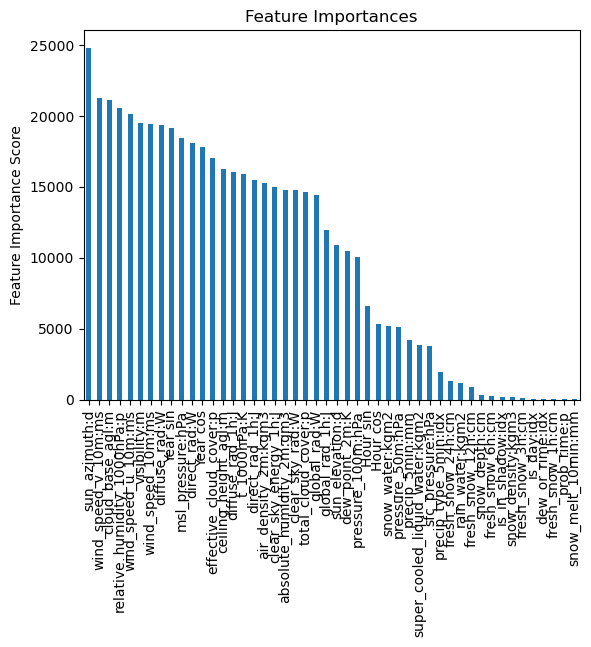

In [500]:
model_a = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=2065,
 max_depth=10,
 min_child_weight=6,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.65,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
 reg_alpha = 10,
 reg_lambda=150,
)

#base: 111.09641204863941 124.56255801196808
#65.99057396142592 125.93691245063847 n=738
#131.64369181722458 122.00666540716254 n=208


#base: 105.33756293468628 383.8196609452916 n = 152
#17.5695410377437 384.28811429850225 -First iterartion n=187
# after tuning 16.355338298122554 383.00759136113936 n=500 eta=0.2
#14.818497119536108 373.6695394079827 eta=0.05 n = 2065




modelfit(model_a, train_data_a, train_a_y, val_data_a, val_a_y, useTrainCV = True)

[13:52:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:52:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:52:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:52:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:52:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	train-mae:38.65612+0.24142	test-mae:38.77343+0.82287
[1]	train-mae:33.19808+0.24688	test-mae:33.54371+0.60094
[2]	train-mae:29.15384+0.17430	test-mae:29.69330+0.54794
[3]	train-mae:26.21372+0.20087	test-mae:26.96027+0.47916
[4]	train-mae:24.00752+0.19021	test-mae:24.93771+0.42453
[5]	train-mae:2

[130]	train-mae:8.95296+0.14902	test-mae:15.87757+0.63884
[131]	train-mae:8.92076+0.15670	test-mae:15.86886+0.64181
[132]	train-mae:8.87340+0.15856	test-mae:15.85003+0.65130
[133]	train-mae:8.83336+0.16451	test-mae:15.82808+0.65399
[134]	train-mae:8.79915+0.15717	test-mae:15.81043+0.64138
[135]	train-mae:8.75752+0.14883	test-mae:15.78651+0.62322
[136]	train-mae:8.72209+0.15385	test-mae:15.77356+0.61363
[137]	train-mae:8.68806+0.14649	test-mae:15.76716+0.61964
[138]	train-mae:8.66053+0.14548	test-mae:15.76362+0.62052
[139]	train-mae:8.62516+0.12751	test-mae:15.74227+0.63371
[140]	train-mae:8.58528+0.13867	test-mae:15.72508+0.63124
[141]	train-mae:8.55671+0.13640	test-mae:15.71609+0.62289
[142]	train-mae:8.52987+0.13269	test-mae:15.71061+0.61901
[143]	train-mae:8.50482+0.12992	test-mae:15.70837+0.62203
[144]	train-mae:8.47545+0.13120	test-mae:15.69803+0.61193
[145]	train-mae:8.44699+0.12574	test-mae:15.68865+0.60823
[146]	train-mae:8.41306+0.11612	test-mae:15.67920+0.60876
[147]	train-ma

[272]	train-mae:5.74467+0.04473	test-mae:14.90798+0.51388
[273]	train-mae:5.72903+0.04644	test-mae:14.90958+0.51225
[274]	train-mae:5.71797+0.04521	test-mae:14.90372+0.51449
[275]	train-mae:5.70441+0.04500	test-mae:14.90407+0.51243
[276]	train-mae:5.69179+0.04604	test-mae:14.90317+0.51458
[277]	train-mae:5.67691+0.04816	test-mae:14.89673+0.51223
[278]	train-mae:5.65961+0.05013	test-mae:14.89468+0.51015
[279]	train-mae:5.64535+0.04783	test-mae:14.88837+0.51185
[280]	train-mae:5.63365+0.04234	test-mae:14.88735+0.50992
[281]	train-mae:5.61826+0.04429	test-mae:14.88060+0.51221
[282]	train-mae:5.60230+0.04529	test-mae:14.87338+0.51833
[283]	train-mae:5.59282+0.04529	test-mae:14.86965+0.51794
[284]	train-mae:5.57804+0.04042	test-mae:14.86761+0.51635
[285]	train-mae:5.56504+0.03757	test-mae:14.86685+0.51426
[286]	train-mae:5.55180+0.03970	test-mae:14.86630+0.51484
[287]	train-mae:5.53448+0.03907	test-mae:14.86583+0.51096
[288]	train-mae:5.52302+0.03716	test-mae:14.86098+0.50971
[289]	train-ma

[414]	train-mae:4.05661+0.05307	test-mae:14.52807+0.48927
[415]	train-mae:4.04193+0.05062	test-mae:14.52085+0.49336
[416]	train-mae:4.03456+0.05135	test-mae:14.51895+0.49421
[417]	train-mae:4.02511+0.05144	test-mae:14.51659+0.49408
[418]	train-mae:4.01464+0.05105	test-mae:14.51418+0.49377
[419]	train-mae:4.00495+0.05148	test-mae:14.51492+0.49457
[420]	train-mae:3.99402+0.05538	test-mae:14.51375+0.49337
[421]	train-mae:3.98610+0.05509	test-mae:14.51286+0.49279
[422]	train-mae:3.97646+0.05530	test-mae:14.51169+0.49204
[423]	train-mae:3.96964+0.05648	test-mae:14.51122+0.49269
[424]	train-mae:3.96006+0.05586	test-mae:14.50561+0.49256
[425]	train-mae:3.95091+0.05747	test-mae:14.50324+0.49354
[426]	train-mae:3.94401+0.05681	test-mae:14.50346+0.49303
[427]	train-mae:3.93292+0.05806	test-mae:14.50091+0.49041
[428]	train-mae:3.92407+0.05738	test-mae:14.49990+0.48934
[429]	train-mae:3.91701+0.05538	test-mae:14.49887+0.48973
[430]	train-mae:3.91097+0.05392	test-mae:14.49913+0.48981
[431]	train-ma

[54]	validation_0-mae:12.96525	validation_1-mae:121.86381
[55]	validation_0-mae:12.90438	validation_1-mae:121.89185
[56]	validation_0-mae:12.80675	validation_1-mae:121.67358
[57]	validation_0-mae:12.65495	validation_1-mae:121.59595
[58]	validation_0-mae:12.54778	validation_1-mae:121.89861
[59]	validation_0-mae:12.48003	validation_1-mae:121.99784
[60]	validation_0-mae:12.41399	validation_1-mae:122.09942
[61]	validation_0-mae:12.38128	validation_1-mae:122.17963
[62]	validation_0-mae:12.34183	validation_1-mae:122.29037
[63]	validation_0-mae:12.28494	validation_1-mae:122.40388
[64]	validation_0-mae:12.24840	validation_1-mae:122.23695
[65]	validation_0-mae:12.23430	validation_1-mae:122.57404
[66]	validation_0-mae:12.19583	validation_1-mae:122.56099
[67]	validation_0-mae:12.16821	validation_1-mae:122.59997
[68]	validation_0-mae:12.04684	validation_1-mae:122.68451
[69]	validation_0-mae:12.02133	validation_1-mae:122.86227
[70]	validation_0-mae:12.01013	validation_1-mae:122.93170
[71]	validatio

[195]	validation_0-mae:7.83015	validation_1-mae:125.25874
[196]	validation_0-mae:7.81316	validation_1-mae:125.26101
[197]	validation_0-mae:7.80224	validation_1-mae:125.30838
[198]	validation_0-mae:7.77525	validation_1-mae:125.31850
[199]	validation_0-mae:7.75844	validation_1-mae:125.37682
[200]	validation_0-mae:7.73725	validation_1-mae:125.37603
[201]	validation_0-mae:7.72048	validation_1-mae:125.36217
[202]	validation_0-mae:7.69419	validation_1-mae:125.36227
[203]	validation_0-mae:7.67414	validation_1-mae:125.34657
[204]	validation_0-mae:7.65850	validation_1-mae:125.35241
[205]	validation_0-mae:7.63293	validation_1-mae:125.36895
[206]	validation_0-mae:7.62004	validation_1-mae:125.43770
[207]	validation_0-mae:7.60511	validation_1-mae:125.47694
[208]	validation_0-mae:7.58463	validation_1-mae:125.49378
[209]	validation_0-mae:7.56659	validation_1-mae:125.46483
[210]	validation_0-mae:7.54270	validation_1-mae:125.49482
[211]	validation_0-mae:7.52006	validation_1-mae:125.49465
[212]	validati

[336]	validation_0-mae:5.52428	validation_1-mae:126.30329
[337]	validation_0-mae:5.51474	validation_1-mae:126.29561
[338]	validation_0-mae:5.49965	validation_1-mae:126.28404
[339]	validation_0-mae:5.48378	validation_1-mae:126.28912
[340]	validation_0-mae:5.47818	validation_1-mae:126.21285
[341]	validation_0-mae:5.47150	validation_1-mae:126.24914
[342]	validation_0-mae:5.45959	validation_1-mae:126.26717
[343]	validation_0-mae:5.45142	validation_1-mae:126.33691
[344]	validation_0-mae:5.44033	validation_1-mae:126.32151
[345]	validation_0-mae:5.41869	validation_1-mae:126.31962
[346]	validation_0-mae:5.41097	validation_1-mae:126.35788
[347]	validation_0-mae:5.39803	validation_1-mae:126.37920
[348]	validation_0-mae:5.38397	validation_1-mae:126.38755
[349]	validation_0-mae:5.36919	validation_1-mae:126.38339
[350]	validation_0-mae:5.35500	validation_1-mae:126.39901
[351]	validation_0-mae:5.34782	validation_1-mae:126.38745
[352]	validation_0-mae:5.34254	validation_1-mae:126.32636
[353]	validati

[478]	validation_0-mae:4.14092	validation_1-mae:126.21097
[479]	validation_0-mae:4.13289	validation_1-mae:126.21825
[480]	validation_0-mae:4.12094	validation_1-mae:126.21475
[481]	validation_0-mae:4.11140	validation_1-mae:126.23074
[482]	validation_0-mae:4.10670	validation_1-mae:126.26023
[483]	validation_0-mae:4.09866	validation_1-mae:126.26699
[484]	validation_0-mae:4.09354	validation_1-mae:126.25959
[485]	validation_0-mae:4.08710	validation_1-mae:126.24924
[486]	validation_0-mae:4.08247	validation_1-mae:126.23305
[487]	validation_0-mae:4.07870	validation_1-mae:126.23793
[488]	validation_0-mae:4.07108	validation_1-mae:126.24065
[489]	validation_0-mae:4.06369	validation_1-mae:126.21800
[490]	validation_0-mae:4.05538	validation_1-mae:126.21155
[491]	validation_0-mae:4.04674	validation_1-mae:126.21969
[492]	validation_0-mae:4.03559	validation_1-mae:126.22281
[493]	validation_0-mae:4.02984	validation_1-mae:126.27553
[494]	validation_0-mae:4.02265	validation_1-mae:126.28082
[495]	validati

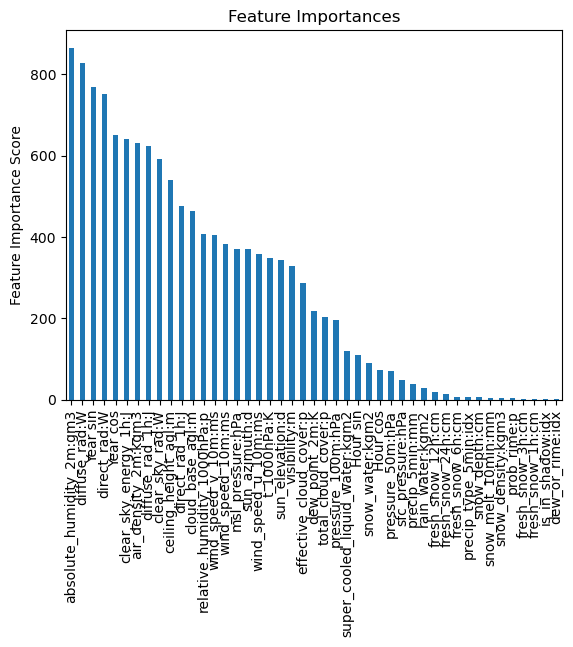

In [506]:
model_b = xgb.XGBRegressor(
 device='cuda',
 learning_rate = 0.2,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
)

#14.594442962612668 23.10780024288535 n=362
#35.26892921016903 22.888491212842357 n=206
#34.76734101188924 22.512291094037696 n= 838

modelfit(model_b, train_data_b, train_b_y, val_data_b, val_b_y, useTrainCV = True)

[13:55:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:55:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:55:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:55:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[13:55:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	train-mae:51.46918+0.38575	test-mae:51.63448+1.71927
[1]	train-mae:42.88747+0.34251	test-mae:43.17961+1.37484
[2]	train-mae:36.26409+0.25567	test-mae:36.65429+1.17647
[3]	train-mae:31.29589+0.25387	test-mae:31.86843+1.01500
[4]	train-mae:27.55984+0.17747	test-mae:28.33083+0.97947
[5]	train-mae:2

[129]	train-mae:10.23478+0.15215	test-mae:18.01858+0.55529
[130]	train-mae:10.20083+0.15966	test-mae:18.02559+0.57329
[131]	train-mae:10.15511+0.15885	test-mae:18.01668+0.57948
[132]	train-mae:10.12351+0.15874	test-mae:18.01239+0.58345
[133]	train-mae:10.09513+0.14655	test-mae:18.01060+0.58862
[134]	train-mae:10.06013+0.15498	test-mae:18.00727+0.59822
[135]	train-mae:10.03136+0.16133	test-mae:18.01401+0.60287
[136]	train-mae:9.99283+0.16324	test-mae:18.01903+0.60398
[137]	train-mae:9.96592+0.16558	test-mae:18.01777+0.60365
[138]	train-mae:9.93075+0.17234	test-mae:18.01434+0.60537
[139]	train-mae:9.89730+0.17524	test-mae:18.01513+0.60895
[140]	train-mae:9.86220+0.18369	test-mae:18.00732+0.62728
[141]	train-mae:9.82169+0.17980	test-mae:17.99730+0.62735
[142]	train-mae:9.79627+0.18436	test-mae:17.99249+0.62989
[143]	train-mae:9.77001+0.17715	test-mae:17.99226+0.63154
[144]	train-mae:9.73766+0.17587	test-mae:17.98709+0.63564
[145]	train-mae:9.71358+0.17817	test-mae:17.98320+0.62958
[146]	t

[271]	train-mae:6.67273+0.07570	test-mae:17.70764+0.60552
[272]	train-mae:6.65301+0.07539	test-mae:17.70721+0.60685
[273]	train-mae:6.63452+0.07356	test-mae:17.70336+0.61059
[274]	train-mae:6.61830+0.07617	test-mae:17.69913+0.61001
[275]	train-mae:6.60025+0.07921	test-mae:17.69898+0.61530
[276]	train-mae:6.57869+0.07683	test-mae:17.69658+0.61506
[277]	train-mae:6.56548+0.07705	test-mae:17.69831+0.61605
[278]	train-mae:6.54605+0.07400	test-mae:17.69524+0.61581
[279]	train-mae:6.53244+0.07464	test-mae:17.69538+0.61349
[280]	train-mae:6.51444+0.07653	test-mae:17.68711+0.61128
[281]	train-mae:6.49588+0.07835	test-mae:17.68263+0.61477
[282]	train-mae:6.48076+0.07871	test-mae:17.68166+0.61627
[283]	train-mae:6.46354+0.07653	test-mae:17.67686+0.61861
[284]	train-mae:6.44762+0.07132	test-mae:17.67911+0.61619
[285]	train-mae:6.43106+0.07123	test-mae:17.67949+0.61655
[286]	train-mae:6.41400+0.07483	test-mae:17.67645+0.62252
[287]	train-mae:6.39460+0.07402	test-mae:17.67796+0.61842
[288]	train-ma

[40]	validation_0-mae:15.17631	validation_1-mae:122.05278
[41]	validation_0-mae:15.15274	validation_1-mae:122.15444
[42]	validation_0-mae:15.04902	validation_1-mae:122.15523
[43]	validation_0-mae:14.92326	validation_1-mae:122.43152
[44]	validation_0-mae:14.89122	validation_1-mae:122.53705
[45]	validation_0-mae:14.86399	validation_1-mae:122.53718
[46]	validation_0-mae:14.74742	validation_1-mae:121.77267
[47]	validation_0-mae:14.66542	validation_1-mae:121.73603
[48]	validation_0-mae:14.55138	validation_1-mae:121.79604
[49]	validation_0-mae:14.49682	validation_1-mae:121.87066
[50]	validation_0-mae:14.42915	validation_1-mae:121.84155
[51]	validation_0-mae:14.37287	validation_1-mae:121.94741
[52]	validation_0-mae:14.29034	validation_1-mae:122.22483
[53]	validation_0-mae:14.26035	validation_1-mae:122.20178
[54]	validation_0-mae:14.21251	validation_1-mae:122.25782
[55]	validation_0-mae:14.19386	validation_1-mae:122.24567
[56]	validation_0-mae:14.13200	validation_1-mae:122.47694
[57]	validatio

[181]	validation_0-mae:9.35590	validation_1-mae:124.14022
[182]	validation_0-mae:9.33461	validation_1-mae:124.14006
[183]	validation_0-mae:9.30421	validation_1-mae:124.09152
[184]	validation_0-mae:9.29468	validation_1-mae:124.20329
[185]	validation_0-mae:9.27483	validation_1-mae:124.22954
[186]	validation_0-mae:9.24877	validation_1-mae:124.20579
[187]	validation_0-mae:9.23982	validation_1-mae:124.16668
[188]	validation_0-mae:9.21208	validation_1-mae:124.01864
[189]	validation_0-mae:9.17832	validation_1-mae:124.03835
[190]	validation_0-mae:9.15863	validation_1-mae:124.01183
[191]	validation_0-mae:9.13945	validation_1-mae:124.01186
[192]	validation_0-mae:9.12589	validation_1-mae:123.98987
[193]	validation_0-mae:9.10379	validation_1-mae:123.97969
[194]	validation_0-mae:9.06183	validation_1-mae:124.06222
[195]	validation_0-mae:9.04874	validation_1-mae:124.06627
[196]	validation_0-mae:9.02396	validation_1-mae:124.09060
[197]	validation_0-mae:9.01152	validation_1-mae:124.08153
[198]	validati

[323]	validation_0-mae:6.54605	validation_1-mae:125.21435
[324]	validation_0-mae:6.52336	validation_1-mae:125.20600
[325]	validation_0-mae:6.50748	validation_1-mae:125.24234
[326]	validation_0-mae:6.49088	validation_1-mae:125.23511
[327]	validation_0-mae:6.47932	validation_1-mae:125.24704
[328]	validation_0-mae:6.46726	validation_1-mae:125.23345
[329]	validation_0-mae:6.44580	validation_1-mae:125.24112
[330]	validation_0-mae:6.43328	validation_1-mae:125.21330
[331]	validation_0-mae:6.41872	validation_1-mae:125.16159
[332]	validation_0-mae:6.39999	validation_1-mae:125.14625
[333]	validation_0-mae:6.39216	validation_1-mae:125.16393
[334]	validation_0-mae:6.37780	validation_1-mae:125.15518
[335]	validation_0-mae:6.36354	validation_1-mae:125.16318
[336]	validation_0-mae:6.34976	validation_1-mae:125.15796
[337]	validation_0-mae:6.33607	validation_1-mae:125.12805
[338]	validation_0-mae:6.32517	validation_1-mae:125.16111
[339]	validation_0-mae:6.30900	validation_1-mae:125.14277
[340]	validati

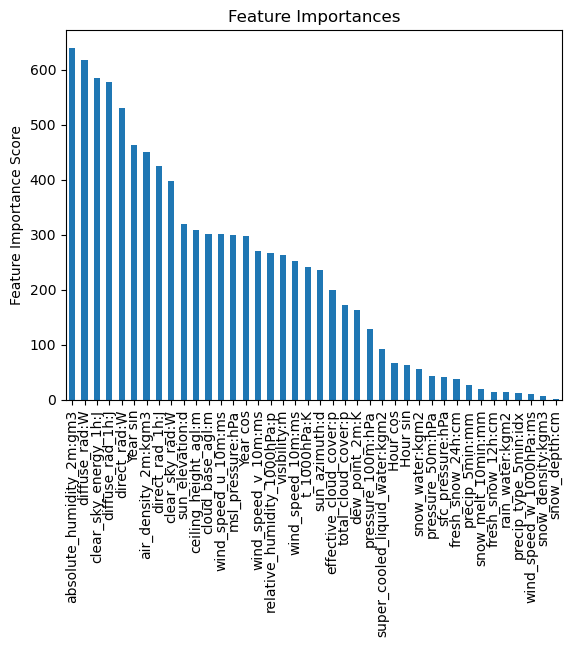

In [508]:
model_c = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.80,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
)


#1.0618119474231693 21.17037693958478 n= 2040
#15.95340 19.69661 n=122

modelfit(model_c, train_data_c, train_c_y, val_data_c, val_c_y, useTrainCV = True)

In [ ]:
preds_a_train = model_a.predict(train_data_a)
preds_a_val = model_a.predict(val_data_a)
preds_a_test = model_a.predict(test_a)

preds_b_train = model_b.predict(train_data_b)
preds_b_val = model_b.predict(val_data_b)
preds_b_test = model_b.predict(test_b)

preds_c_train = model_c.predict(train_data_c)
preds_c_val = model_c.predict(val_data_c)
preds_c_test = model_c.predict(test_c)

fig, axs = plt.subplots(7, figsize=(10, 15))
axs[0].plot(train_a_y, color="blue")
axs[0].plot(preds_a_train, color="red", alpha=0.7)

axs[1].plot(val_a_y, color="blue")
axs[1].plot(preds_a_val, color="red", alpha=0.7)


axs[2].plot(train_b_y, color="blue")
axs[2].plot(preds_b_train, color="red", alpha=0.7)

axs[3].plot(val_b_y, color="blue")
axs[3].plot(preds_b_val, color="red", alpha=0.7)

axs[4].plot(train_c_y, color="blue")
axs[4].plot(preds_c_train, color="red", alpha=0.7)

axs[5].plot(val_c_y, color="blue")
axs[5].plot(preds_c_val, color="red", alpha=0.7)

axs[6].plot(preds_a_test, color="blue")
axs[6].plot(preds_b_test, color="green")
axs[6].plot(preds_c_test, color="red")




In [493]:
param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,6,2)
}

#a
#{'max_depth': 9, 'min_child_weight': 5},
# -183.31388081479835)

#b
#{'max_depth': 3, 'min_child_weight': 5},
# -41.066349863792624)


#c
#{'max_depth': 9, 'min_child_weight': 5},
# -27.524814791002843)


param_test1b = {
 'max_depth': [10 ,11],
 'min_child_weight': [6, 7]
}

#a
# {'max_depth': 10, 'min_child_weight': 6},
# -182.6444338408607)


# {'max_depth': 2, 'min_child_weight': 6},
# -40.88009131082275)
    

# {'max_depth': 10, 'min_child_weight': 5},
# -27.471507183091255)

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
#a
# {'gamma': 0.2},
# -182.6248590260013)

#{'gamma': 0.0},
# -40.88009131082275)

#{'gamma': 0.1},
# -27.436416210468003)

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
#a
# {'colsample_bytree': 0.7, 'subsample': 0.9},
# -182.89352746151783)


# {'colsample_bytree': 0.8, 'subsample': 0.8},
#-40.79319608864614)

#{'colsample_bytree': 0.9, 'subsample': 0.9},
# -27.047177346042083)

param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
#a
#{'colsample_bytree': 0.65, 'subsample': 0.9},
# -182.86245409103773)

# {'colsample_bytree': 0.8, 'subsample': 0.8},
# -40.79319608864614)

#{'colsample_bytree': 0.85, 'subsample': 0.9},
# -26.964328085222814)

param_test6 = {
 #'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}

#a
# {'reg_alpha': 10},
# -181.58462466418706)

# {'reg_lambda': 150},
# -174.53377571548492)


#  {'reg_alpha': 0.1, 'reg_lambda': 1},
#-40.79316057080198)
    
# {'reg_alpha': 1e-05, 'reg_lambda': 100},
# -26.41113725236746)

param_test7 = {
 #'reg_alpha':[10, 30, 50, 70],
 'reg_lambda': [125, 150, 175]
}

# {'reg_alpha': 99},
# -220.7881065081092)

#  {'reg_alpha': 0.05, 'reg_lambda': 1},
# -40.79317658702995)

#{'reg_alpha': 0.05, 'reg_lambda': 75},
# -26.38086368275504)


gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=187,
 max_depth=10,
 min_child_weight=6,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.65,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 scale_pos_weight=1,
 booster='gbtree',
 reg_alpha = 10,
 reg_lambda=150,
), 
 param_grid = param_test7, scoring='neg_mean_absolute_error',n_jobs=4, cv=5, verbose=3)


gsearch1.fit(train_data_a,train_a_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[13:14:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.



({'mean_fit_time': array([50.27595687, 66.0223887 , 50.38555465]),
  'std_fit_time': array([ 7.81076489,  0.78692298, 13.59717964]),
  'mean_score_time': array([0.0576066 , 0.06170082, 0.06119976]),
  'std_score_time': array([0.01365662, 0.01286813, 0.01105415]),
  'param_reg_lambda': masked_array(data=[125, 150, 175],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_lambda': 125}, {'reg_lambda': 150}, {'reg_lambda': 175}],
  'split0_test_score': array([-146.75962322, -147.2648461 , -146.34939968]),
  'split1_test_score': array([-157.79398644, -156.66205002, -157.70446205]),
  'split2_test_score': array([-205.44051529, -203.42067925, -202.96040069]),
  'split3_test_score': array([-230.37048025, -224.65413286, -224.53678918]),
  'split4_test_score': array([-137.61283974, -140.66717035, -141.28821447]),
  'mean_test_score': array([-175.59548899, -174.53377572, -174.56785321]),
  'std_test_score': array([36.00585384, 33.33

In [194]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [250]:
MAX_EPOCHS = 30

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [251]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [252]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [253]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [254]:
lstm_model_a = tf.keras.models.Sequential([ 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=48, bias_initializer=initializers.Constant(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=64, bias_initializer=initializers.Constant(0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),

    tf.keras.layers.Dense(units=1, activation="relu", bias_initializer=initializers.Constant(0.1))

])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [255]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.0038667283952236176, 0.024362364783883095]
#[0.004080631770193577, 0.023939160630106926]

Epoch 1/30
31/31 [==============================] - 28s 288ms/step - loss: 0.0345 - mean_absolute_error: 0.0956 - val_loss: 0.0078 - val_mean_absolute_error: 0.0353
Epoch 2/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0119 - mean_absolute_error: 0.0556 - val_loss: 0.0053 - val_mean_absolute_error: 0.0295
Epoch 3/30
31/31 [==============================] - 6s 179ms/step - loss: 0.0098 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0280
Epoch 4/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0088 - mean_absolute_error: 0.0476 - val_loss: 0.0049 - val_mean_absolute_error: 0.0273
Epoch 5/30
31/31 [==============================] - 6s 200ms/step - loss: 0.0082 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_absolute_error: 0.0268
Epoch 6/30
31/31 [==============================] - 6s 206ms/step - loss: 0.0081 - mean_absolute_error: 0.0450 - val_loss: 0.0045 - val_mean_absolute_error: 0.0261
Epoch 7/30
31/3

In [256]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

# [0.003871380351483822, 0.023782264441251755]

Epoch 1/30
30/30 [==============================] - 33s 407ms/step - loss: 0.0383 - mean_absolute_error: 0.0877 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 2/30
30/30 [==============================] - 6s 187ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 3/30
30/30 [==============================] - 7s 231ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.0296 - mean_absolute_error: 0.0589
measure b: [0.02958689071238041, 0.05894533544778824]


In [257]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.0031701738480478525, 0.023126540705561638]

Epoch 1/30
25/25 [==============================] - 42s 512ms/step - loss: 0.0388 - mean_absolute_error: 0.0907 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 2/30
25/25 [==============================] - 6s 223ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 3/30
25/25 [==============================] - 6s 252ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 4/30
4/4 [==============================] - 0s 62ms/step - loss: 0.0163 - mean_absolute_error: 0.0458
measure c: [0.016322463750839233, 0.04580168426036835]


In [258]:
#lstm_model_a.get_weight_paths()

In [259]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

pred_a_train = lstm_model_a.predict(train_a_x)
pred_b_train = lstm_model_b.predict(train_b_x)
pred_c_train = lstm_model_c.predict(train_c_x)

25/25 [==============================] - 2s 93ms/step


In [260]:
pred_a = pred_a.flatten() * a_max / pred_a.max()
pred_b = pred_b.flatten() * b_max / pred_b.max()
pred_c = pred_c.flatten() * c_max / pred_c.max()

pred_a_val = pred_a_val.flatten() * a_max / pred_a_val.max()
pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()

pred_a_train = pred_a_train.flatten() * a_max / pred_a_train.max()
pred_b_train = pred_b_train.flatten() * b_max / pred_b_train.max()
pred_c_train = pred_c_train.flatten() * c_max / pred_c_train.max()

C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:2: RuntimeWarning: invalid value encountered in divide
  pred_b = pred_b.flatten() * b_max / pred_b.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:3: RuntimeWarning: invalid value encountered in divide
  pred_c = pred_c.flatten() * c_max / pred_c.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:6: RuntimeWarning: invalid value encountered in divide
  pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: divide by zero encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: invalid value encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:10: RuntimeWarning: divide by zero encountered in divid

In [261]:
#lstm_model_a.save("./a_2.keras")
#lstm_model_b.save("./b_2.keras")
#lstm_model_c.save("./c_2.keras")

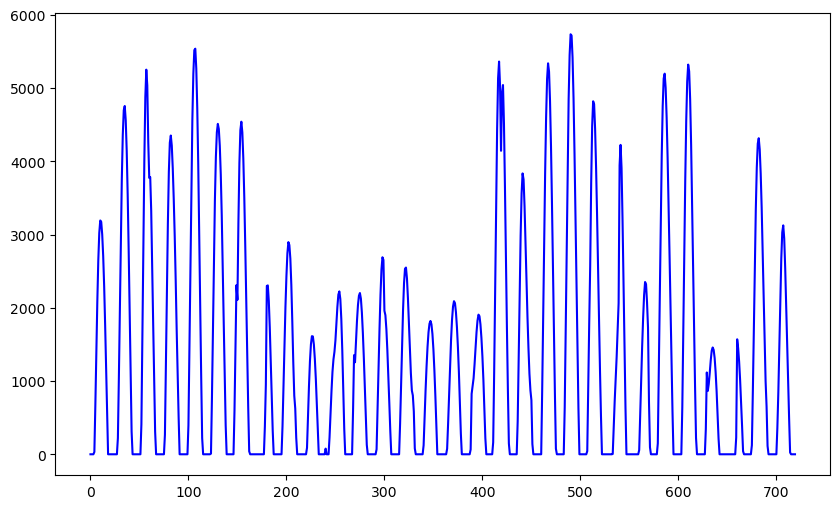

In [262]:
plt.figure(figsize=(10,6))
plt.plot(pred_a, color="blue")
plt.plot(pred_b, color="red")
plt.plot(pred_c, color="green")

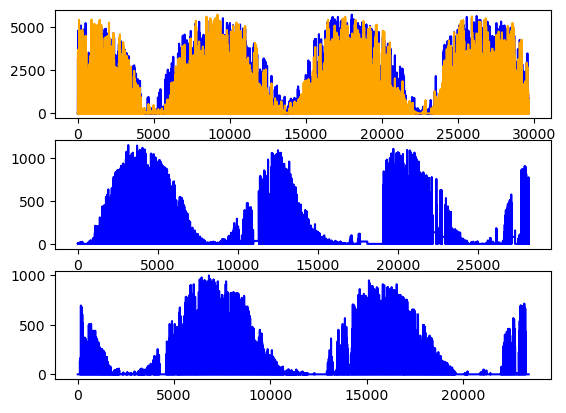

In [263]:

fig, axs = plt.subplots(3)

axs[0].plot(train_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_train, color="orange")

axs[1].plot(train_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_train, color="orange")

axs[2].plot(train_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_train, color="orange")

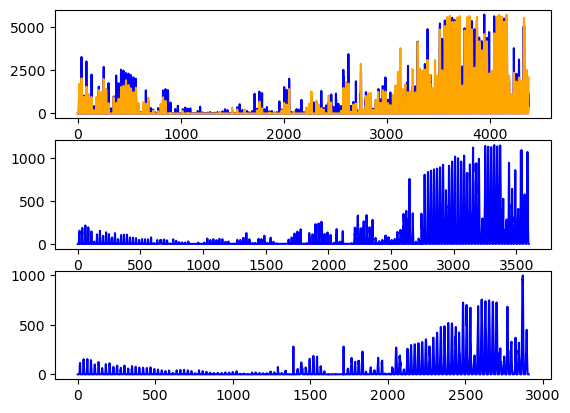

In [264]:
fig, axs = plt.subplots(3)

axs[0].plot(val_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_val, color="orange")

axs[1].plot(val_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_val, color="orange")

axs[2].plot(val_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_val, color="orange")

In [228]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [229]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [230]:
submit = np.concatenate((np.concatenate((preds_a_test, preds_b_test)),preds_c_test))

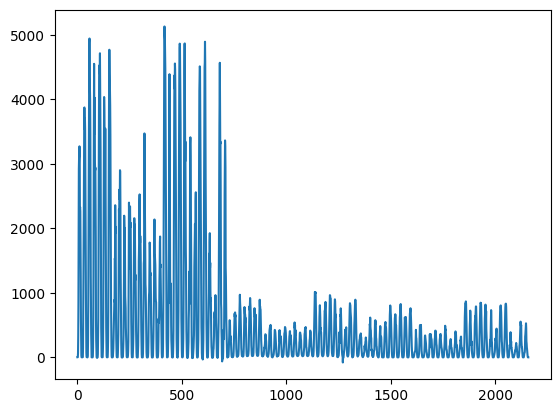

In [231]:
plt.plot(submit)

In [232]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("xgboost_3.csv", index=False)